Install required packages for radar data visualization:

mamba install pyart_mch scikit-image scikit-learn pandas xarray -c conda-forge

pip config --user set global.index-url https://service.meteoswiss.ch/nexus/repository/python-all/simple

pip config --user set global.trusted-host service.meteoswiss.ch

pip install py-radlib

pyart_mch documentation: https://meteoswiss.github.io/pyart/notebooks/read_mch_metranet_data.html

Data structure:
* path: /store_new/mch/msrad/radar/swiss/data/
* for dealiased velocity: /store_new/mch/mfeldman/R2D2_YYYY/
* sorted by years, within years in zipped file per day of year
* date notation: YYDDD (days since the beginning of the year, from 001 - 366)
* unzip data you want to work with to your scratch: unzip -d /scratch/mch/fackerma/directoryname MLA21165.zip

File names:
* ??A - Albis radar, ??D - La Dôle, ??L - Monte Lema, ??P - Pointe de la Plaine Morte, ??W - Weissfluhjoch, ??C or ??X - Cartesian composite
* ML? - file with polarimetric radar data
* DV? - dealiased radar data
* CZC - max. reflectivity composite
* RZC - radar-derived rain rate composite
* AZC - radar-derived rain accumulation composite
* VA? - vertical wind profile above radar
* HZC - freezing level height (smoothed from COSMO/ICON)
* MZC - MESHS (maximum expected severe hail size)
* BZC - Probability of hail
* TRTC - thunderstorm radar tracking (very important for your work!)

In [2]:
import pyart
import glob
import numpy as np
import matplotlib.pyplot as plt
import radlib
import os
import h5py
os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def transform_from_digital(mydata, nyquist):
    """
    transforms digital number to velocity

    Parameters
    ----------
    mydata : array
        velocity data as digital number.
    nyquist : float
        nyquist velocity / bounding velocity.

    Returns
    -------
    myfinaldata : array
        velocity data in m/s.

    """
    ##transform digital number to Doppler velocity (MCH)
    myfinaldata = (mydata*1.0 - 128)*nyquist/127
    myfinaldata[mydata==0]=np.nan

    return myfinaldata

In [4]:
path = '/store_new/mch/msrad/mfeldman/case/'
file = glob.glob(path+'ML*23000U.005') # ML File
file2 = glob.glob('/store_new/mch/msrad/mfeldman/case/srn/data/tmp/mof/DVL/*23007L.805') # Dealiased velocity file
file3 = glob.glob(path+'CZC232372300VL.801') # composite file (here reflectivity, but procedure applies to all Cartesian composites)


In [15]:
## How to read ML file and extract data ##
data=pyart.aux_io.read_metranet(file[0],reader='python')
velocity=data.get_field(0,'velocity')
reflectivity=data.get_field(0,'reflectivity').data

## How to read DV file and extract data ##
dv_data = pyart.aux_io.read_file_py(file2[0],physic_value = False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq=float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)

## How to read Cartesian file and extract data ##
#c_data = pyart.aux_io.read_cartesian_metranet(file3[0])
c_data = radlib.read_file(file3[0],physic_value=True)
czc=c_data.data


py_decoder DBG verb=0
py_decoder DBG verbl=0


In [18]:
# Check if there's a header or metadata attribute
if hasattr(c_data, 'header'):
    print(c_data.header)
elif hasattr(c_data, 'metadata'):
    print(c_data.metadata)
else:
    print("No metadata found")


{'row': '640', 'column': '710', 'data_type': 'FLOAT', 'pid': 'CZC', 'product': 'Column_Max@swp_1_to_20', 't_ver': '2.4.7.53 Jan 24 2023', 'p_ver': '1.0.2', 'a_ver': '1.0.0', 'time': '2323723000', 'format': 'RECT', 'moment': 'UZ', 'data_unit': 'dBZ', 'radar': 'ADLPW', 'quality': '77777', 'data_width': '0.499998', 'volume_time': '1693004400', 'data_bits': '8', 'total_sweep': '20', 'compressed_bytes': '103387', 'uncompressed_bytes': '454400', 'rect_xres': '1.000000', 'rect_yres': '1.000000', 'table_num': '1', 'table_name': '8bit_metranet_dbz', 'table_size': '1024', 'table_endianness': 'big', 'usr_radar_required': 'ADLPW', 'usr_quality': '55555', 'usr_visib_lower': '50', 'usr_visib_upper': '200', 'usr_speckle_filt': '0', 'GateWidth': '0.499998', 'filename': 'CZC232372300VL.801'}


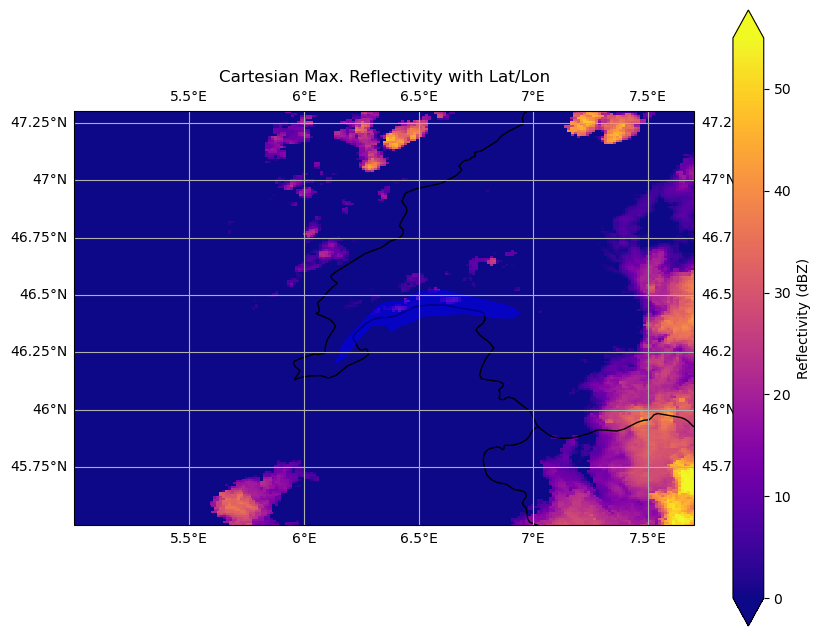

In [20]:


# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)

# Initialize transformer for Swiss grid to WGS84 (EPSG:21781 to EPSG:4326)
transformer = Transformer.from_crs(21781, 4326, always_xy=True)

# Convert Swiss grid coordinates to lat/lon
lons, lats = transformer.transform(X, Y)

# Create the figure and axes with the appropriate projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent [min_lon, max_lon, min_lat, max_lat]
ax.set_extent([5, 7.7, 45.5, 47.3])

# Plot the radar data (reflectivity in this case) using pcolormesh
cmap = plt.cm.plasma
cmap.set_bad(color='gray')
p1 = ax.pcolormesh(lons, lats, czc, vmin=0, vmax=55, cmap=cmap)

# Add a colorbar
cbar = plt.colorbar(p1, ax=ax, extend='both')
cbar.set_label('Reflectivity (dBZ)')

# Add features: coastlines, borders, and lakes
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, color='blue', alpha=0.5)

# Add gridlines for better reference
ax.gridlines(draw_labels=True)

# Set title
ax.set_title('Cartesian Max. Reflectivity with Lat/Lon')

# Show the plot
plt.show()


All fields in ML files:
* reflectivity_hh_clut
* spectrum_width
* velocity
* uncorrected_differential_phase
* uncorrected_cross_correlation_ratio
* differential_reflectivity
* reflectivity_vv
* reflectivity
* signal_to_noise_ratio

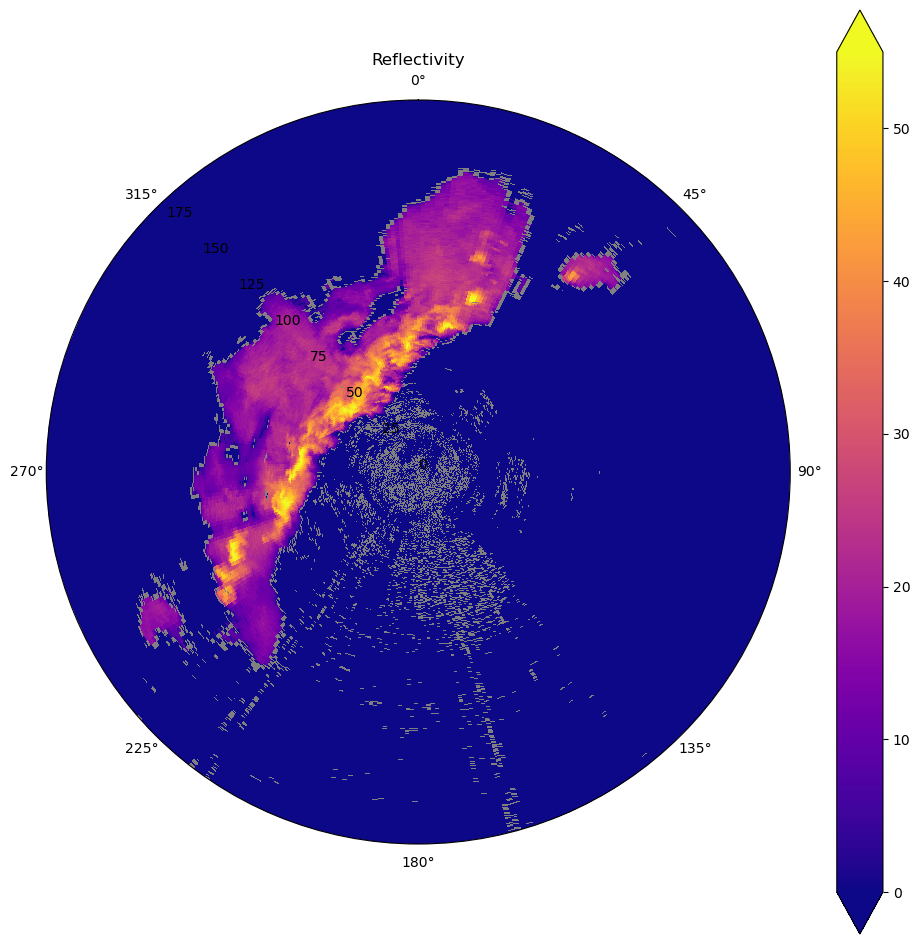

In [6]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1, 1, 1, projection='polar')
ax.set_theta_offset(0.5*np.pi)
ax.set_theta_direction(-1)
ax.set_rlabel_position(315)
cmap=plt.cm.plasma
cmap.set_bad(color='gray')
resolution = 0.5
r, theta = np.meshgrid(np.arange(0, reflectivity.shape[1]*resolution, resolution),np.radians(np.linspace(0, 360, 360)))
p1=plt.pcolormesh(theta, r, reflectivity, vmin=0, vmax=55, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('Reflectivity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

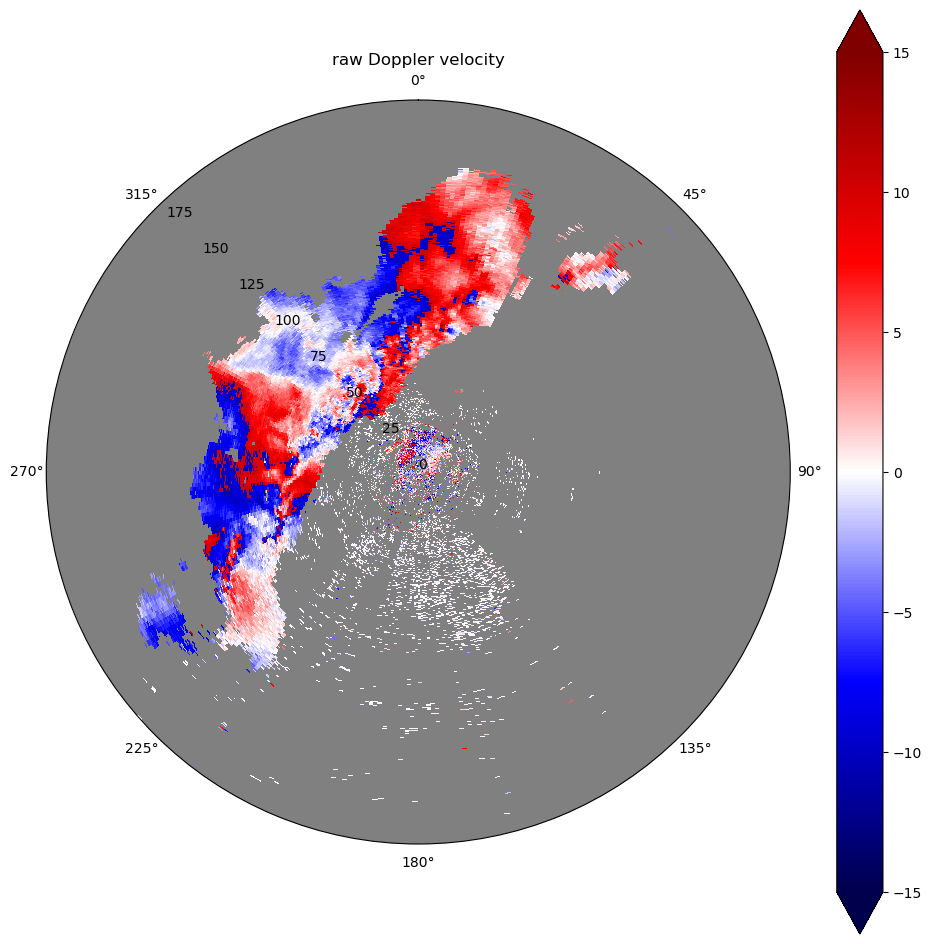

In [7]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1, 1, 1, projection='polar')
ax.set_theta_offset(0.5*np.pi)
ax.set_theta_direction(-1)
ax.set_rlabel_position(315)
cmap=plt.cm.seismic
cmap.set_bad(color='gray')
resolution = 0.5
r, theta = np.meshgrid(np.arange(0, velocity.shape[1]*resolution, resolution),np.radians(np.linspace(0, 360, 360)))
p1=plt.pcolormesh(theta, r, velocity, vmin=-15, vmax=15, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('raw Doppler velocity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

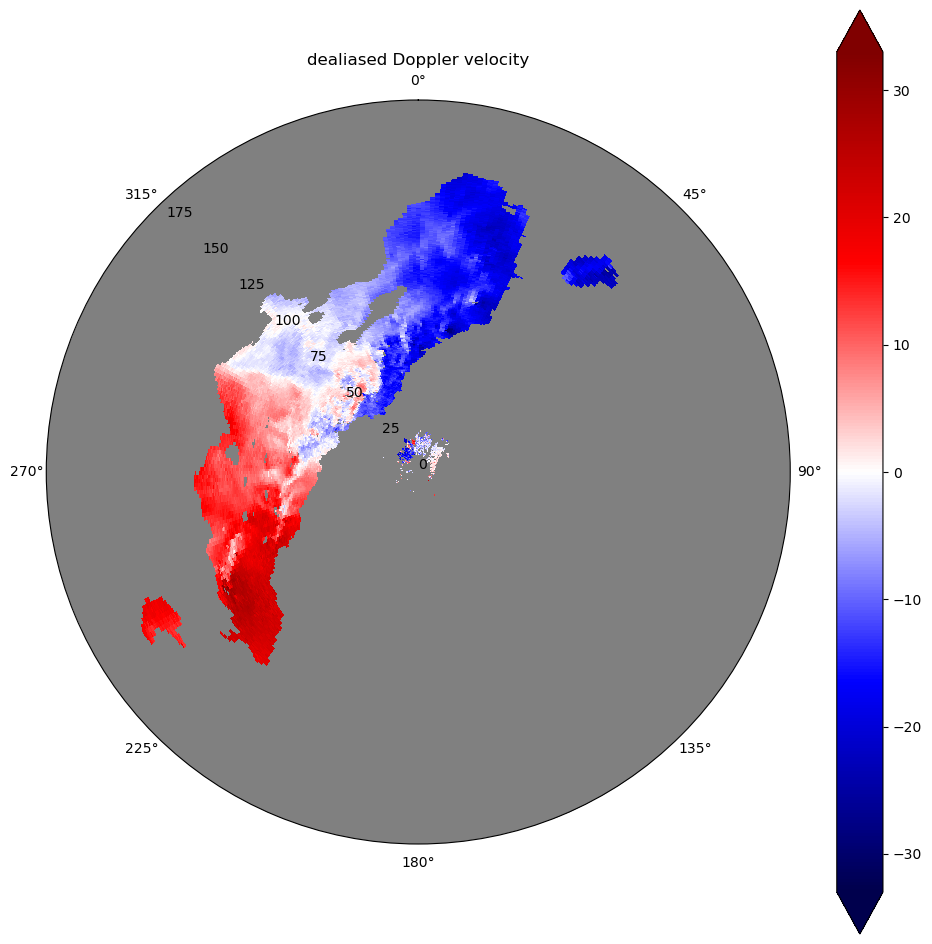

In [8]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1, 1, 1, projection='polar')
ax.set_theta_offset(0.5*np.pi)
ax.set_theta_direction(-1)
ax.set_rlabel_position(315)
cmap=plt.cm.seismic
cmap.set_bad(color='gray')
resolution = 0.5
r, theta = np.meshgrid(np.arange(0, dv_velocity.shape[1]*resolution, resolution),np.radians(np.linspace(0, 360, 360)))
p1=plt.pcolormesh(theta, r, dv_velocity, vmin=-33, vmax=33, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('dealiased Doppler velocity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

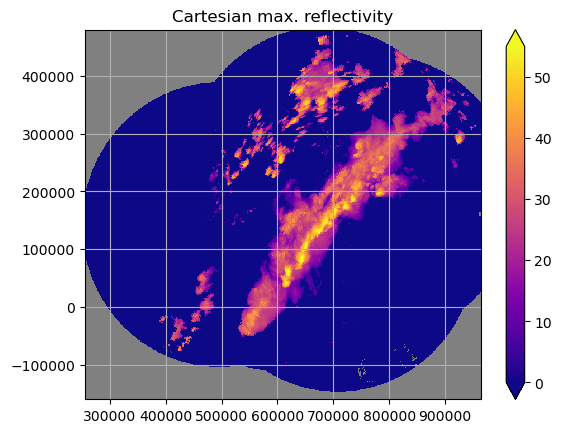

In [9]:

fig=plt.figure()
cmap=plt.cm.plasma
cmap.set_bad(color='gray')
#Swiss grid coordinates for Cartesian radar field
chx = np.arange(255000,255000+710*1000+1,1000)
chy = sorted(np.arange(-160000,-160000+640*1000+1,1000),reverse=True)
X,Y = np.meshgrid(chx,chy)
p1=plt.pcolormesh(X,Y,czc, vmin=0, vmax=55, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('Cartesian max. reflectivity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

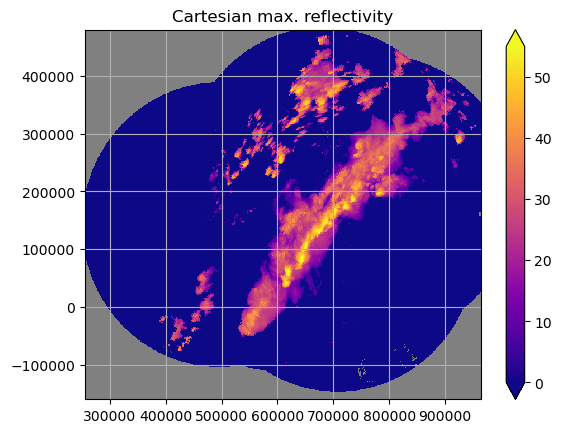

In [13]:
fig=plt.figure()
cmap=plt.cm.plasma
cmap.set_bad(color='gray')
#Swiss grid coordinates for Cartesian radar field
chx = np.arange(255000,255000+710*1000+1,1000)
chy = sorted(np.arange(-160000,-160000+640*1000+1,1000),reverse=True)
X,Y = np.meshgrid(chx,chy)
p1=plt.pcolormesh(X,Y,czc, vmin=0, vmax=55, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('Cartesian max. reflectivity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)